# STL + ARIMA Imputation

## Load Data

In [42]:
## Libraries
# lightkurve
#import lightkurve as lk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
#import statsmodels.api as sm
# import itertools
# import warnings
## Pyramid ARIMA
from pmdarima import auto_arima

In [25]:
## Data
df = pd.read_csv("../0.Data/031381302.csv", index_col = "time")

# Check
print(df.shape)
#df.info()

## Time Series of interest
lightcurve = df.loc[:, ["pdcsap_flux"]]
# # Set "time" as index
# pdcsap.set_index("time", inplace=True)
lightcurve.sort_index(inplace=True)
# lightcurve = lightcurve.sort_values("time")

# Check
print(lightcurve.shape); lightcurve.info(); lightcurve.head()

(17719, 23)
(17719, 1)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 17719 entries, 1437.978645522663 to 1464.2854684532865
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pdcsap_flux  17033 non-null  float64
dtypes: float64(1)
memory usage: 276.9 KB


,pdcsap_flux
time,
1437.978646,NaN
1437.980034,NaN
1437.981423,NaN
1437.982812,NaN
1437.984201,NaN


## Add Missing Indices

To impute missing observations, we begin by adding the missing indices/time stamps.

In [34]:
## Time Differences (2-min cadence)
time_diffs = lightcurve.index.to_series().diff()

## Setup
lc_fill = lightcurve.copy()
med = time_diffs.median()
cur = 1

## Iteratively add indices where missing
for k, id in enumerate(lightcurve.index):
    if k == 0: continue
    # print(k, id)
    diff = time_diffs.iloc[k] #id - pdcsap["time"][k - 1]
    diff_size = diff / med
    if diff_size < 2:
        pass
    elif (diff_size >= 2) & (diff_size < 3):
        newRows = pd.DataFrame({"pdcsap_flux": np.nan}, index = [id - med])
        lc_fill = pd.concat([lc_fill, newRows])
    else:
        newInds = np.arange(start = lightcurve.index[k - 1] + med, stop = id - med, step = med)
        newRows = pd.DataFrame({"pdcsap_flux": np.nan}, index = newInds)
        lc_fill = pd.concat([lc_fill, newRows])

## Cleanup
lc_fill.sort_index(inplace = True)

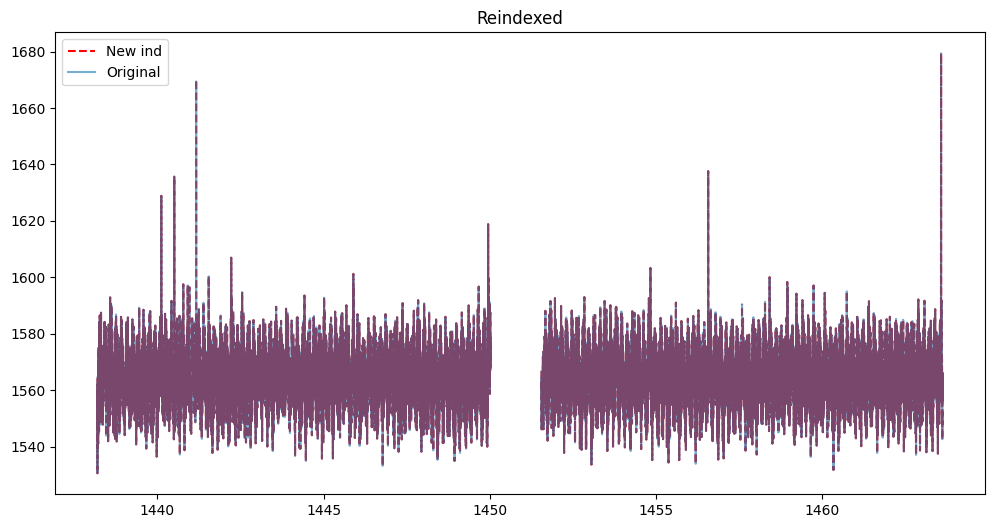

In [ ]:
## Check
lc_fill.info()

# Plot
plt.figure(figsize=(12,6))
plt.plot(lc_fill, label='New ind', linestyle='--', color='red')
plt.plot(lightcurve, label='Original', alpha=0.6)
plt.title("Reindexed")
plt.legend()
plt.show()

## STL

In [37]:
## Identify null_indices
null_indices = lc_fill[lc_fill.isna()].index
print(null_indices[0:5])

Float64Index([ 1437.978645522663, 1437.9800344004182, 1437.9814232781732,
              1437.9828121559574, 1437.9842010337416],
             dtype='float64')


In [38]:
print(lightcurve.describe())

## Impute missing values (temporary)
# pdcsap_mod: Modified pdcsap_flux by imputing them with the mean (temporary).
lc_fill.fillna(lc_fill["pdcsap_flux"].mean(), inplace=True)

# Check
lc_fill.describe()

        pdcsap_flux
count  17033.000000
mean    1564.459684
std        9.316531
min     1530.508200
25%     1558.114900
50%     1564.397800
75%     1570.626300
max     1679.386400


,pdcsap_flux
count,18856.000000
mean,1564.459684
std,8.854699
min,1530.508200
25%,1558.935550
50%,1564.459684
75%,1569.906650
max,1679.386400


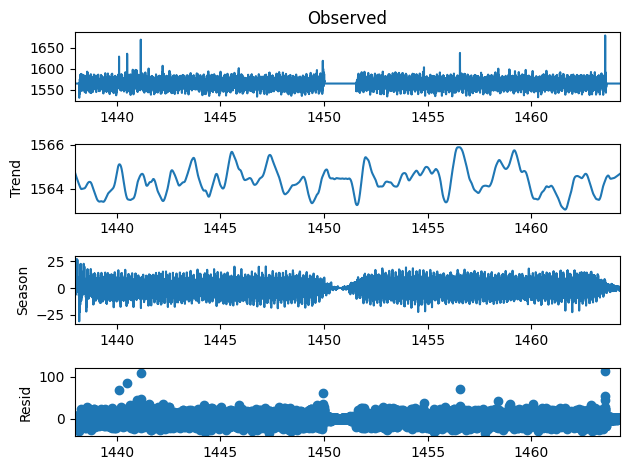

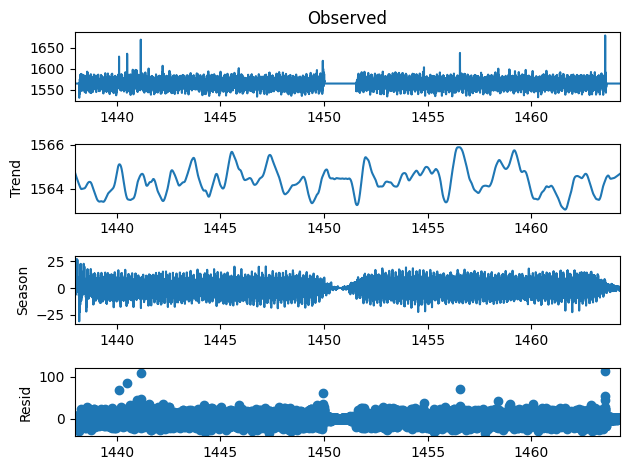

In [40]:
## STL Decomposition
stl = STL(lc_fill, period=240, robust=True)  # Use period=240 based on EDA
decomposition = stl.fit()

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

## Plot
decomposition.plot()

In [41]:
# Check
residual.info(); residual.head()

residual.describe()

<class 'pandas.core.series.Series'>
Float64Index: 18856 entries, 1437.978645522663 to 1464.2854684532865
Series name: resid
Non-Null Count  Dtype  
--------------  -----  
18856 non-null  float64
dtypes: float64(1)
memory usage: 294.6 KB


count    18856.000000
mean         0.106673
std          6.714784
min        -34.267261
25%         -2.966608
50%          0.001416
75%          3.065438
max        113.875131
Name: resid, dtype: float64

## ARIMA Imputation

In [43]:
## Function to automatically impute using auto_arima
def auto_arima_impute(series, null_inds,
                      start_p = 0, max_p = 5, start_q = 0, max_q = 5):
    """
    Impute missing values using auto_arima model.
    Parameters:
        series (pd.Series): Time series data with NaN values
        seasonal (bool): If True, fit seasonal ARIMA
        m (int): Seasonal period for SARIMA
    Returns:
        pd.Series: Imputed time series
    """
    series_filled = series.copy()
    
    # Fit auto_arima on non-missing values
    model = auto_arima(series,
                       start_p = start_p, max_p = max_p,
                       start_q = start_q, max_q = max_q,
                       seasonal=False,
                       information_criterion= "aic",
                       trace=True)
    
    print(f"Selected ARIMA order: {model.order}")

    d = model.order[1]
    pred_vals = model.predict_in_sample(start = d, end = series_filled.shape[0] - 1)
    series_filled.loc[null_inds[np.isin(null_inds, series.index[d:])]] = pred_vals[np.isin(series.index[d:], null_inds)] 
    
    return series_filled

In [44]:
## Impute missing values using auto_arima for trend and residual
trend_filled = auto_arima_impute(trend, null_indices)
residual_filled = auto_arima_impute(residual, null_indices)

# Assume the seasonal component remains unchanged
seasonal_filled = seasonal

# Reconstruct the imputed time series
pdcsap_imputed = trend_filled + seasonal_filled + residual_filled

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-159938.984, Time=1.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=5.64 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-159940.930, Time=0.63 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-343594.232, Time=10.54 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-396236.488, Time=10.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=6.93 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-396142.549, Time=5.25 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-396303.654, Time=5.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-354308.108, Time=14.60 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-325592.462, Time=29.72 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-396360.354, Time=18.68 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-361405.996, Time=19.44 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-396400.817, Time=28.97 sec
 ARIMA(4

C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(4,1,3)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "C:\Users\alexd\AppDat

 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=nan sec

Best model:  ARIMA(4,1,3)(0,0,0)[0] intercept
Total fit time: 795.287 seconds
Selected ARIMA order: (4, 1, 3)
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=125332.169, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=125187.489, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=125202.391, Time=0.41 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=125128.270, Time=0.29 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=125083.620, Time=0.38 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=125060.557, Time=0.65 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=125038.998, Time=0.81 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=124950.670, Time=3.85 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=124949.909, Time=2.69 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=124947.908, Time=2.47 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=124945.918, Time=1.16 sec
 ARIMA(1,0,1)(0,0,0)[0]             : 

In [61]:
## Test ##
res_trend_fill = auto_arima_impute(trend + residual, null_indices)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=330896.355, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=1.30 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=125339.472, Time=0.66 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=125289.167, Time=1.27 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=125256.978, Time=5.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=125253.840, Time=7.53 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=125237.242, Time=10.34 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=10.73 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=125239.662, Time=6.35 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=125130.780

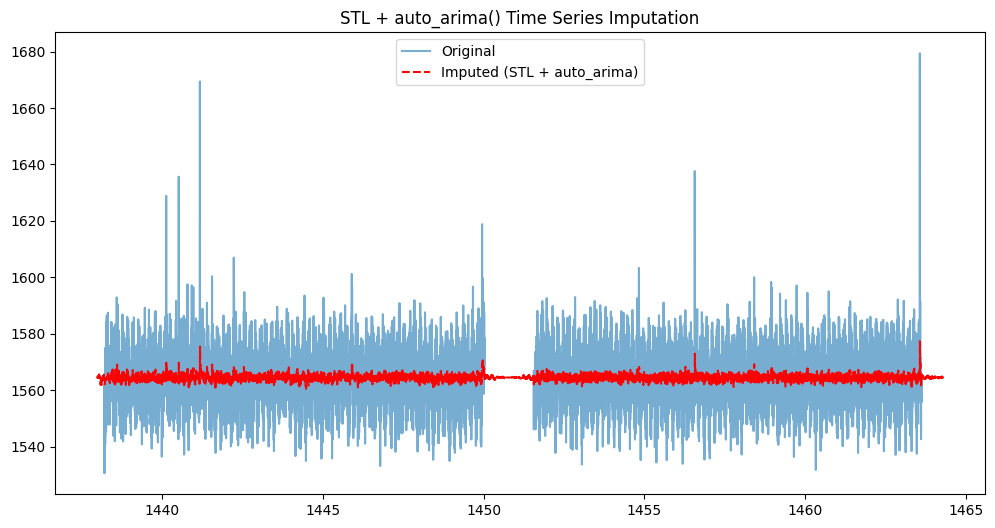

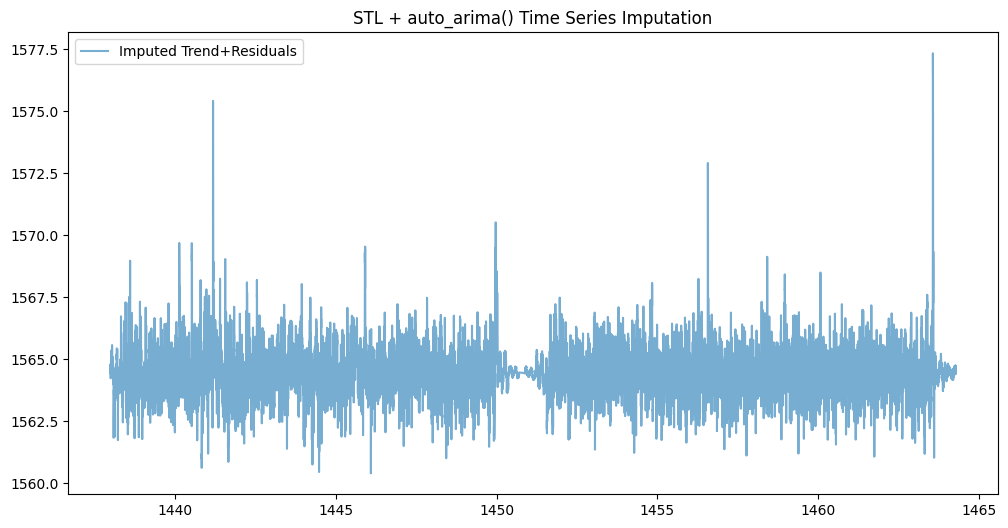

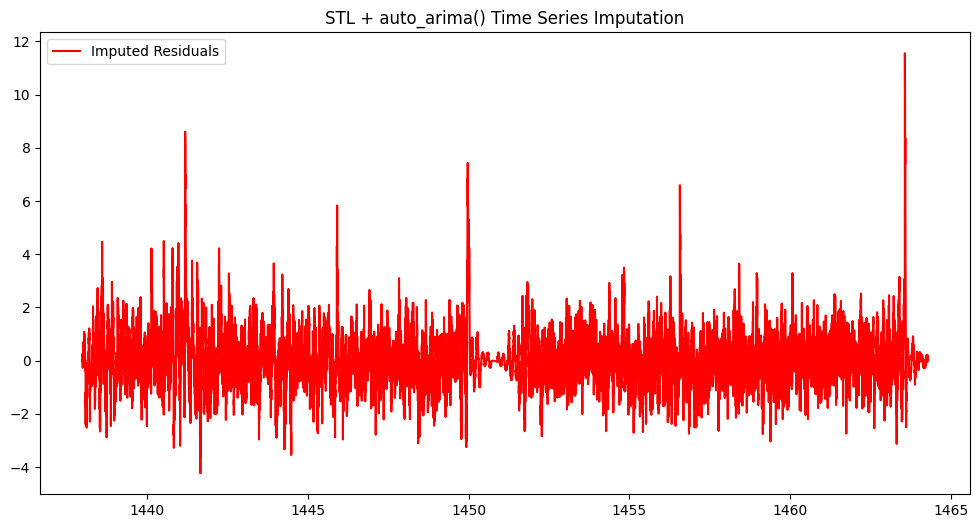

In [65]:
## Check
# Plot original vs imputed series
plt.figure(figsize=(12,6))
plt.plot(lightcurve, label='Original', alpha=0.6)
plt.plot(res_trend_fill, label='Imputed (STL + auto_arima)', linestyle='--', color='red')
#plt.plot(residual + trend + seasonal, label='STL', alpha=0.2)
plt.title("STL + auto_arima() Time Series Imputation")
plt.legend()
plt.show()

# Plot trend+residuals
plt.figure(figsize=(12,6))
plt.plot(res_trend_fill, label='Imputed Trend+Residuals', alpha = 0.6)
plt.title("STL + auto_arima() Time Series Imputation")
plt.legend()
plt.show()

# Plot residuals
plt.figure(figsize=(12,6))
plt.plot(residual_filled, label='Imputed Residuals', color='red')
plt.title("STL + auto_arima() Time Series Imputation")
plt.legend()
plt.show()

In [67]:
## Save the imputed dataset
lc_fill["pdcsap_imputed"] = res_trend_fill #pdcsap_imputed
lc_fill["signal"] = residual
lc_fill["trend"] = trend
lc_fill["seasonal"] = seasonal
lc_fill.to_csv("../0.Data/031381302_imputed.csv")

In [68]:
# Check
lc_fill.info()
lc_fill.head()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 18856 entries, 1437.978645522663 to 1464.2854684532865
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pdcsap_flux     18856 non-null  float64
 1   pdcsap_imputed  18856 non-null  float64
 2   signal          18856 non-null  float64
 3   trend           18856 non-null  float64
 4   seasonal        18856 non-null  float64
dtypes: float64(5)
memory usage: 1.4 MB


,pdcsap_flux,pdcsap_imputed,signal,trend,seasonal
1437.978646,1564.459684,1564.463230,1.423914,1564.788866,-1.753096
1437.980034,1564.459684,1564.629985,-1.225973,1564.784308,0.901349
1437.981423,1564.459684,1564.493020,1.204118,1564.779761,-1.524195
1437.982812,1564.459684,1564.637737,2.528983,1564.775225,-2.844523
1437.984201,1564.459684,1564.811253,0.485369,1564.770699,-0.796384
